In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns 
from pandas.plotting import scatter_matrix

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import diffprivlib as dp

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResults
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SingleSliceSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingFeature
import nbfuns
import importlib
importlib.reload(nbfuns)

#import statsmodels.api as sm
import sys
import warnings

%matplotlib inline
#%matplotlib notebook

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
CLF_RANDOM_STATE=1234
DP_CLF_RANDOM_STATE=13371337
SHADOW_RANDOM_STATE=22222222
SPLIT_RANDOM_STATE=303030
RF_RANDOM_STATE=51516321

In [2]:
paths = ["./pickles/attack_results_purchase100-small.p",
         "./pickles/attack_results_purchase100-small-early-stopping.p",
         "./pickles/attack_results_purchase100-small-dpsgd.p",
         "./pickles/attack_results_purchase100.p",
         "./pickles/attack_results_purchase100-early-stopping.p",
         "./pickles/attack_results_purchase100-dpsgd.p"]

names = ["Small NN",
         "Small NN + ES",
         "Small NN + DP",
         "Large NN",
         "Large NN + ES",
         "Large NN + DP"]

pandas_names = ["purchase100-small-pandas.csv",
                "purchase100-small-early-stopping-pandas.csv",
                "purchase100-small-dpsgd-pandas.csv",
                "purchase100-pandas.csv",
                "purchase100-early-stopping-pandas.csv",
                "purchase100-dpsgd-pandas.csv"]

In [3]:
importlib.reload(nbfuns)
from nbfuns import threshold_tpr_fpr

dframes = []
curves = []
for i, path in enumerate(paths):
    attacks_result = AttackResults.load(path)
    rates = []
    for j in range(3):
        _, tpr, fpr = threshold_tpr_fpr(attacks_result.single_attack_results[j])
        rates.append((tpr, fpr))
    
    print(attacks_result.single_attack_results[1])
    curves.append(attacks_result.single_attack_results[1].roc_curve)
    res_df = attacks_result.calculate_pd_dataframe()
    res_df.to_csv("./pickles/results-csv/" + pandas_names[i])
    new_df = pd.DataFrame(res_df[res_df["slice feature"] == "Entire dataset"])
    new_df["TPR-FPR"] = tuple(np.around(rates, decimals=3))
    new_df["Model"] = [names[i]] * 3
    dframes.append(new_df)

final_df = pd.concat(dframes)
cols = final_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_df = final_df[cols]
final_df.drop(columns=["Attacker advantage", "slice value", "slice feature", "train size", "test size"], inplace=True, axis=1)
final_df

For threshold 0.5 found TPR, FPR [0.111 0.412 0.   ]
For threshold 0.5 found TPR, FPR [0.501 0.801 0.003]
For threshold 0.5 found TPR, FPR [0.6   0.829 0.061]
SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=24665, ntest=24665)
  AttackType: RANDOM_FOREST
  AUC: 0.95
  Attacker advantage: 0.80
)
For threshold 0.5 found TPR, FPR [0.5   0.419 0.027]
For threshold 0.5 found TPR, FPR [0.5   0.538 0.098]
For threshold 0.5 found TPR, FPR [0.571 0.597 0.199]
SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=24665, ntest=24665)
  AttackType: RANDOM_FOREST
  AUC: 0.77
  Attacker advantage: 0.44
)
For threshold 0.5 found TPR, FPR [0.139 0.399 0.   ]
For threshold 0.5 found TPR, FPR [0.499 0.815 0.004]
For threshold 0.5 found TPR, FPR [0.571 0.826 0.044]
SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=24665, ntest=24665)
  AttackType: RANDOM_FOREST
  AUC: 0.95
  Attacker advantage: 0.81
)
For threshold 0.5 found TPR, FPR [0.505 0.208 0.013]

Model          attack type       AUC         TPR-FPR
0       Small NN     THRESHOLD_ATTACK  0.875893    (0.412, 0.0)
1       Small NN        RANDOM_FOREST  0.949981  (0.801, 0.003)
2       Small NN  K_NEAREST_NEIGHBORS  0.931788  (0.829, 0.061)
0  Small NN + ES     THRESHOLD_ATTACK  0.737124  (0.419, 0.027)
1  Small NN + ES        RANDOM_FOREST  0.767468  (0.538, 0.098)
2  Small NN + ES  K_NEAREST_NEIGHBORS  0.746261  (0.597, 0.199)
0  Small NN + DP     THRESHOLD_ATTACK  0.879928    (0.399, 0.0)
1  Small NN + DP        RANDOM_FOREST  0.950350  (0.815, 0.004)
2  Small NN + DP  K_NEAREST_NEIGHBORS  0.940121  (0.826, 0.044)
0       Large NN     THRESHOLD_ATTACK  0.666322  (0.208, 0.013)
1       Large NN        RANDOM_FOREST  0.682749  (0.427, 0.124)
2       Large NN  K_NEAREST_NEIGHBORS  0.652029  (0.528, 0.315)
0  Large NN + ES     THRESHOLD_ATTACK  0.587703   (0.33, 0.186)
1  Large NN + ES        RANDOM_FOREST  0.593125  (0.417, 0.276)
2  Large NN + ES  K_NEAREST_NEIGHBORS  0.561308    (0.52, 0.43)
0  Large NN + DP     THRESHOLD_ATTACK  0.670889  (0.192, 0.004)
1  Large NN + DP        RANDOM_FOREST  0.687232  (0.411, 0.101)
2  Large NN + DP  K_NEAREST_NEIGHBORS  0.662859  (0.528, 0.289)

For threshold 0.0 found TPR, FPR [0.259 1.    1.   ]
For threshold 0.1 found TPR, FPR [0.259 1.    1.   ]
For threshold 0.2 found TPR, FPR [0.259 1.    1.   ]
For threshold 0.3 found TPR, FPR [0.303 0.999 0.998]
For threshold 0.4 found TPR, FPR [0.4   0.661 0.435]
For threshold 0.5 found TPR, FPR [0.5   0.411 0.101]
For threshold 0.6 found TPR, FPR [0.6   0.364 0.055]
For threshold 0.7 found TPR, FPR [0.7   0.317 0.029]
For threshold 0.8 found TPR, FPR [0.8   0.257 0.012]
For threshold 0.9 found TPR, FPR [0.899 0.102 0.003]
For threshold 1.0 found TPR, FPR [0.998 0.    0.   ]


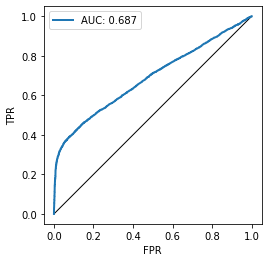

In [4]:
importlib.reload(nbfuns)

from nbfuns import find_nearest, threshold_tpr_fpr
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import plotting

#attacks_result.single_attack_results[0].roc_curve.thresholds[ind[0][1]]
#attacks_result.single_attack_results[0].roc_curve.fpr[ind[0][1]]

plotting.plot_roc_curve(attacks_result.single_attack_results[1].roc_curve)
for i in range(0, 11):
    threshold_tpr_fpr(attacks_result.single_attack_results[1], i/10)

In [44]:
# Save dataframe to latex
tex_path = "./pickles/latex/purchase100-entire-dataset.tex"
final_df.to_latex(tex_path)single_attack_results

In [50]:
res_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   slice feature       309 non-null    object 
 1   slice value         309 non-null    object 
 2   train size          309 non-null    int64  
 3   test size           309 non-null    int64  
 4   attack type         309 non-null    object 
 5   Attacker advantage  309 non-null    float64
 6   AUC                 309 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 17.0+ KB


<Figure size 439.352x271.535 with 0 Axes>

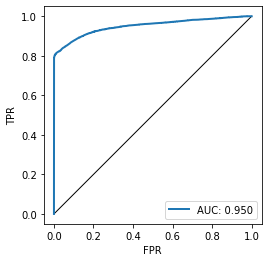

<Figure size 439.352x271.535 with 0 Axes>

<Figure size 439.352x271.535 with 0 Axes>

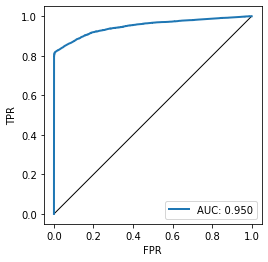

<Figure size 439.352x271.535 with 0 Axes>

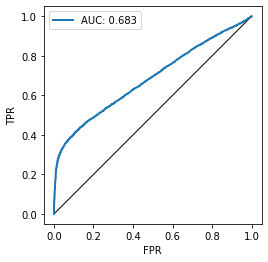

<Figure size 439.352x271.535 with 0 Axes>

<Figure size 439.352x271.535 with 0 Axes>

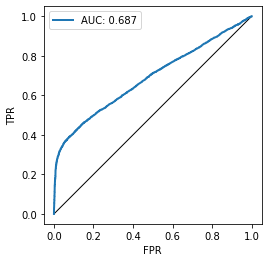

In [25]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import plotting
importlib.reload(nbfuns)

for i, curve in enumerate(curves):
    plt.figure(figsize=nbfuns._DEFAULT_FIGSIZE)
    plotting.plot_roc_curve(curve)
    #plt.title(names[i] + ": RF Attack AUC")
    #plt.show()
    #plt.savefig("./img/purchase100-rocs-entire-dataset/" + names[i] + ".pdf", bbox_inches='tight')

In [5]:
paths = ["./pickles/adult_attack_results_lr.p",
         "./pickles/adult_attack_results_dplr.p",
         "./pickles/adult_attack_results_random_forests.p",
         "./pickles/adult_attack_results_dprf.p",
         "./pickles/adult_attack_results_cnb.p",
         "./pickles/adult_attack_results_decision_trees.p"]

names = ["LR",
         "DPLR",
         "RF",
         "DPRF",
         "CNB",
         "DT"]

pandas_names = ["adult-lr-pandas.csv",
                "adult-dplr-pandas.csv",
                "adult-rf-pandas.csv",
                "adult-dprf-pandas.csv",
                "adult-cnb-pandas.csv",
                "adult-dt-pandas.csv"]

In [6]:
dframes = []
curves = []
for i, path in enumerate(paths):
    attacks_result = AttackResults.load(path)
    print(attacks_result.single_attack_results[1])
    curves.append(attacks_result.single_attack_results[1].roc_curve)
    res_df = attacks_result.calculate_pd_dataframe()
    res_df.to_csv("./pickles/results-csv/" + pandas_names[i])
    new_df = pd.DataFrame(res_df[res_df["slice feature"] == "Entire dataset"])
    new_df["Model"] = [names[i]] * 3
    dframes.append(new_df)
    
final_df = pd.concat(dframes)
cols = final_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_df = final_df[cols]
final_df.drop(columns=["Attacker advantage", "slice value", "slice feature", "train size", "test size"], inplace=True, axis=1)
final_df

SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=24421, ntest=24421)
  AttackType: RANDOM_FOREST
  AUC: 0.50
  Attacker advantage: 0.01
)
SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=24421, ntest=24421)
  AttackType: RANDOM_FOREST
  AUC: 0.49
  Attacker advantage: 0.02
)
SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=24421, ntest=24421)
  AttackType: RANDOM_FOREST
  AUC: 0.63
  Attacker advantage: 0.20
)
SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=24421, ntest=24421)
  AttackType: RANDOM_FOREST
  AUC: 0.49
  Attacker advantage: 0.02
)
SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=24421, ntest=24421)
  AttackType: RANDOM_FOREST
  AUC: 0.51
  Attacker advantage: 0.02
)
SingleAttackResult(
  SliceSpec: Entire dataset
  DataSize: (ntrain=24421, ntest=24421)
  AttackType: RANDOM_FOREST
  AUC: 0.60
  Attacker advantage: 0.17
)


Model          attack type       AUC
0    LR     THRESHOLD_ATTACK  0.505043
1    LR        RANDOM_FOREST  0.502477
2    LR  K_NEAREST_NEIGHBORS  0.505589
0  DPLR     THRESHOLD_ATTACK  0.502786
1  DPLR        RANDOM_FOREST  0.486310
2  DPLR  K_NEAREST_NEIGHBORS  0.505983
0    RF     THRESHOLD_ATTACK  0.596816
1    RF        RANDOM_FOREST  0.631436
2    RF  K_NEAREST_NEIGHBORS  0.580948
0  DPRF     THRESHOLD_ATTACK  0.504535
1  DPRF        RANDOM_FOREST  0.492356
2  DPRF  K_NEAREST_NEIGHBORS  0.500300
0   CNB     THRESHOLD_ATTACK  0.504712
1   CNB        RANDOM_FOREST  0.507547
2   CNB  K_NEAREST_NEIGHBORS  0.496621
0    DT     THRESHOLD_ATTACK  0.584209
1    DT        RANDOM_FOREST  0.600743
2    DT  K_NEAREST_NEIGHBORS  0.605724

In [96]:
tex_path = "./pickles/latex/adult-entire-dataset.tex"
final_df.to_latex(tex_path)

In [8]:
models_small = ["./trained_models/fractions/purchase100-0.8-samples.hdf5",
          "./trained_models/fractions/purchase100-0.7-samples.hdf5",
          "./trained_models/fractions/purchase100-0.6-samples.hdf5",
          "./trained_models/fractions/purchase100-0.5-samples.hdf5"]
results_small = ["./pickles/fractions/purchase100-0.8-samples.p",
           "./pickles/fractions/purchase100-0.7-samples.p",
           "./pickles/fractions/purchase100-0.6-samples.p",
           "./pickles/fractions/purchase100-0.5-samples.p"]

In [9]:
from keras import backend as K
from experiments import models, data_utils

fractions = [0.8, 0.7, 0.6, 0.5]

def evaluate_models_fractions(model_paths, data_fractions, small=True):
    train_accs = []
    test_accs = []
    for i, model_path in enumerate(model_paths):
        model = models.model_purchase100(small=small)
        model.load_weights(model_path)
        (x_train, y_train), (x_test, y_test), (x_shadow, y_shadow) = data_utils.load_purchase100(shadow_size=data_fractions[i])

        print("Evaluate on train data")
        train_acc = model.evaluate(x_train, y_train, batch_size=32)
        print("train loss, train acc:", train_acc)
        print("Evaluate on test data")
        test_acc = model.evaluate(x_test, y_test, batch_size=32)
        print("test loss, test acc:", test_acc)

        train_accs.append(train_acc[1])
        test_accs.append(test_acc[1])
        K.clear_session()
    return train_accs, test_accs

In [8]:
train_accs_small, test_accs_small = evaluate_models_fractions(models_small, fractions, small=True)

2022-06-17 19:18:09.539333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 19:18:09.575101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 19:18:09.575439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 19:18:09.576032: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

./datasets/dataset_purchase
Evaluate on train data
617/617 [==============================] - 2s 2ms/step - loss: 4.7550e-07 - accuracy: 1.0000
train loss, train acc: [4.755019631375035e-07, 1.0]
Evaluate on test data
617/617 [==============================] - 1s 2ms/step - loss: 2.0446 - accuracy: 0.6562
test loss, test acc: [2.0445823669433594, 0.6562436819076538]
./datasets/dataset_purchase
Evaluate on train data
925/925 [==============================] - 2s 2ms/step - loss: 1.4358e-06 - accuracy: 1.0000
train loss, train acc: [1.4358184898810578e-06, 1.0]
Evaluate on test data
925/925 [==============================] - 2s 2ms/step - loss: 1.7094 - accuracy: 0.7112
test loss, test acc: [1.7093994617462158, 0.7112064361572266]
./datasets/dataset_purchase
Evaluate on train data
1234/1234 [==============================] - 2s 2ms/step - loss: 1.0142 - accuracy: 0.7507
train loss, train acc: [1.0141526460647583, 0.7507348656654358]
Evaluate on test data
1234/1234 [======================

In [10]:
models_large = ["./trained_models/fractions/purchase100-large-0.8-samples.hdf5",
                "./trained_models/fractions/purchase100-large-0.7-samples.hdf5",
                "./trained_models/fractions/purchase100-large-0.6-samples.hdf5",
                "./trained_models/fractions/purchase100-large-0.5-samples.hdf5"]
results_large = ["./pickles/fractions/purchase100-large0.8-samples.p",
                 "./pickles/fractions/purchase100-large0.7-samples.p",
                 "./pickles/fractions/purchase100-large0.6-samples.p",
                 "./pickles/fractions/purchase100-large0.5-samples.p"]

In [10]:
train_accs_large, test_accs_large = evaluate_models_fractions(models_large, fractions, small=False)

./datasets/dataset_purchase
Evaluate on train data
617/617 [==============================] - 2s 2ms/step - loss: 0.0140 - accuracy: 0.9956
train loss, train acc: [0.014029779471457005, 0.9955909252166748]
Evaluate on test data
617/617 [==============================] - 1s 2ms/step - loss: 1.1724 - accuracy: 0.7971
test loss, test acc: [1.1724053621292114, 0.7970808744430542]
./datasets/dataset_purchase
Evaluate on train data
925/925 [==============================] - 2s 2ms/step - loss: 0.0283 - accuracy: 0.9928
train loss, train acc: [0.028330301865935326, 0.9928035736083984]
Evaluate on test data
925/925 [==============================] - 2s 2ms/step - loss: 1.0606 - accuracy: 0.8230
test loss, test acc: [1.0605897903442383, 0.822966992855072]
./datasets/dataset_purchase
Evaluate on train data
1234/1234 [==============================] - 3s 2ms/step - loss: 0.0167 - accuracy: 0.9949
train loss, train acc: [0.016695208847522736, 0.9949321150779724]
Evaluate on test data
1234/1234 [==

In [11]:
def extract_auc_means_errors(results):
    aucs = []
    errors = []
    for result_path in results:
        res = AttackResults.load(result_path)
        res_df = res.calculate_pd_dataframe()
        new_df = pd.DataFrame(res_df[res_df["slice feature"] == "Entire dataset"])
        print(new_df.iloc[1])
        #print((new_df.AUC.mean(), new_df.AUC.sem()))
        aucs.append(new_df.AUC.mean())
        errors.append(new_df.AUC.sem())
    #res_df.to_csv("./pickles/results-csv/" + pandas_names[i])
    #new_df = pd.DataFrame(res_df[res_df["slice feature"] == "Entire dataset"])
    return aucs, errors

In [12]:
aucs_small, errors_small = extract_auc_means_errors(results_small)
aucs_large, errors_large = extract_auc_means_errors(results_large)
print(aucs_small)
print(errors_small)
print(aucs_large)
print(errors_large)

slice feature         Entire dataset
slice value                         
train size                     19732
test size                      19732
attack type            RANDOM_FOREST
Attacker advantage          0.864585
AUC                         0.967342
Name: 1, dtype: object
slice feature         Entire dataset
slice value                         
train size                     29598
test size                      29598
attack type            RANDOM_FOREST
Attacker advantage           0.73848
AUC                         0.924465
Name: 1, dtype: object
slice feature         Entire dataset
slice value                         
train size                     39464
test size                      39464
attack type            RANDOM_FOREST
Attacker advantage          0.651936
AUC                         0.889395
Name: 1, dtype: object
slice feature         Entire dataset
slice value                         
train size                     49331
test size                      49331
attack

In [84]:
importlib.reload(nbfuns)

train_fractions = [0.1, 0.15, 0.2, 0.25]
legend = ["Small: Train acc",
          "Small: Test acc",
          "Large: Train acc",
          "Large: Test acc",
          "Small: Mean attack AUC",
          "Large: Mean Attack AUC",
         ]

plt.figure(figsize=nbfuns._DEFAULT_FIGSIZE)
plt.plot(train_fractions, train_accs_small, "bo", linestyle="dashdot")
plt.plot(train_fractions, test_accs_small, color="orange", marker="o", linestyle=":")
plt.errorbar(train_fractions, aucs_small, yerr=errors_small, color = "green", marker='o', linestyle="solid",linewidth=0.85)

plt.plot(train_fractions, train_accs_large, color="purple", marker="x", linestyle="dashdot")
plt.plot(train_fractions, test_accs_large, color="brown", marker="x", linestyle=":")
plt.errorbar(train_fractions, aucs_large, yerr=errors_large, color = "red", marker='x', linestyle="solid", linewidth=0.85)

plt.grid(visible=True, linewidth=0.25)
plt.legend(legend, bbox_to_anchor=(1.0125, 1.015))
plt.xlabel("Fraction of total data used as training data.")
plt.xticks(list(np.arange(0.10, 0.251, 0.05)))
#plt.savefig("./img/purchase-fractions-accuracies.pdf", bbox_inches="tight")
plt.show()

NameError: name 'train_accs_small' is not defined

<Figure size 439.352x271.535 with 0 Axes>

In [13]:
def extract_auc_means_errors_correct_incorrect(results, correct=True):
    aucs = []
    errors = []
    for result_path in results:
        res = AttackResults.load(result_path)
        res_df = res.calculate_pd_dataframe()
        res_df = pd.DataFrame(res_df[(res_df["slice feature"] == "correctly_classified")])
        print(res_df)
        if correct:
            new_df = pd.DataFrame(res_df[res_df["slice value"] == "True"])
        else:
            new_df = pd.DataFrame(res_df[res_df["slice value"] == "False"])
        #print(new_df)
        #print((new_df.AUC.mean(), new_df.AUC.sem()))
        aucs.append(new_df.AUC.mean())
        errors.append(new_df.AUC.sem())
    #res_df.to_csv("./pickles/results-csv/" + pandas_names[i])
    #new_df = pd.DataFrame(res_df[res_df["slice feature"] == "Entire dataset"])
    return aucs, errors

In [14]:
cor_aucs_small, cor_errors_small = extract_auc_means_errors_correct_incorrect(results_small)
inc_aucs_small, inc_errors_small = extract_auc_means_errors_correct_incorrect(results_small, correct=False)
#inc_aucs_small, inc_errors_small = [0, 0, 0, 0], [0, 0, 0, 0]
print(cor_aucs_small, cor_errors_small)
print(inc_aucs_small, inc_errors_small)

cor_aucs_large, cor_errors_large = extract_auc_means_errors_correct_incorrect(results_large)
inc_aucs_large, inc_errors_large = extract_auc_means_errors_correct_incorrect(results_large, correct=False)
print(cor_aucs_large, cor_errors_large)
print(inc_aucs_large, inc_errors_large)

            slice feature slice value  train size  test size  \
303  correctly_classified        True       19732      13020   
304  correctly_classified        True       13020      13020   
305  correctly_classified        True       13020      13020   

             attack type  Attacker advantage       AUC  
303     THRESHOLD_ATTACK            0.790940  0.864440  
304        RANDOM_FOREST            0.795084  0.949908  
305  K_NEAREST_NEIGHBORS            0.768971  0.930462  
            slice feature slice value  train size  test size  \
303  correctly_classified        True       29598      20945   
304  correctly_classified        True       20945      20945   
305  correctly_classified        True       20945      20945   

             attack type  Attacker advantage       AUC  
303     THRESHOLD_ATTACK            0.654627  0.787933  
304        RANDOM_FOREST            0.665254  0.904126  
305  K_NEAREST_NEIGHBORS            0.630874  0.881302  
            slice feature slic

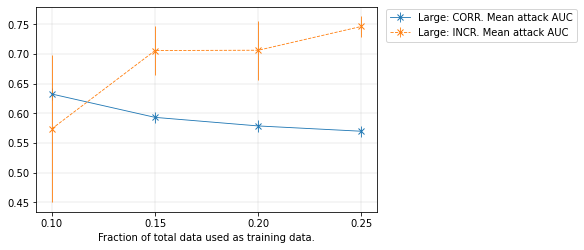

In [86]:
importlib.reload(nbfuns)

train_fractions = [0.1, 0.15, 0.2, 0.25]
legend = ["Large: CORR. Mean attack AUC",
          "Large: INCR. Mean attack AUC"]

plt.figure(figsize=nbfuns._DEFAULT_FIGSIZE)
#plt.errorbar(train_fractions, cor_aucs_small, yerr=cor_errors_small, marker="o", linewidth=0.85)
#plt.errorbar(train_fractions, inc_aucs_small, yerr=inc_errors_small, marker="o", linestyle="dashed", linewidth=0.85)
plt.errorbar(train_fractions, cor_aucs_large, yerr=cor_errors_large, marker="x", linewidth=0.85)
plt.errorbar(train_fractions, inc_aucs_large, yerr=inc_errors_large, marker="x",linestyle="dashed", linewidth=0.85)

plt.grid(visible=True, linewidth=0.25)
plt.legend(legend, bbox_to_anchor=(1.0125, 1.015))
plt.xlabel("Fraction of total data used as training data.")
plt.xticks(list(np.arange(0.10, 0.251, 0.05)))
plt.savefig("./img/purchase-fractions-corr-incr.pdf", bbox_inches="tight")
plt.show()

In [69]:
adult_results = ["./pickles/adult_attack_results_lr.p",
                 "./pickles/adult_attack_results_dplr.p",
                 "./pickles/adult_attack_results_random_forests.p",
                 "./pickles/adult_attack_results_dprf.p",
                 "./pickles/adult_attack_results_cnb.p",
                 "./pickles/adult_attack_results_decision_trees.p"]

model_names = ["LR", "DPLR", "RF", "DPRF", "CNB", "DT"]

In [35]:
def extract_auc_means_errors_correct_incorrect_single(result_path, correct=True):
    res = AttackResults.load(result_path)
    res_df = res.calculate_pd_dataframe()
    #
    entire_dset = pd.DataFrame(res_df[(res_df["slice feature"] == "Entire dataset")])
    positive_size = entire_dset["train size"].mean()
    negative_size = entire_dset["test size"].mean()
    
    res_df = pd.DataFrame(res_df[(res_df["slice feature"] == "correctly_classified")])
    if correct:
        new_df = pd.DataFrame(res_df[res_df["slice value"] == "True"])
    else:
        new_df = pd.DataFrame(res_df[res_df["slice value"] == "False"])

    new_df.reset_index(inplace=True)
    print(new_df)
    positive_data_fraction = new_df["train size"].max() / positive_size
    negative_data_fraction = new_df["test size"].max() / negative_size
    
    
    #print(new_df)
    return new_df.AUC.mean(), new_df.AUC.sem(), entire_dset.AUC.max(), positive_data_fraction, negative_data_fraction

In [87]:
adult_cor_inc_df = pd.DataFrame(columns=["Model", "Best AUC", "COR. AUC", "COR. Frac", "INCR. AUC", "INCR. Frac"])
for i, result in enumerate(adult_results):
    cor_mean, cor_err, entire_max_auc, cor_train_fraction, cor_test_fraction = extract_auc_means_errors_correct_incorrect_single(result, correct=True)
    inc_mean, inc_err, _, inc_train_fraction, inc_test_fraction = extract_auc_means_errors_correct_incorrect_single(result, correct=False)
    adult_cor_inc_df.loc[-1] = [
        model_names[i],
        entire_max_auc,
        cor_mean,
        tuple(np.around((cor_train_fraction, cor_test_fraction), decimals=3)),
        inc_mean,
        tuple(np.around((inc_train_fraction, inc_test_fraction), decimals=3))
    ]
    adult_cor_inc_df.index = adult_cor_inc_df.index + 1

adult_cor_inc_df.round(3)
#adult_cor_inc_df.round(3).to_latex("./pickles/latex/adult_correct_incorrect_fractions_aucs.tex", index=False)

Model  Best AUC  COR. AUC       COR. Frac  INCR. AUC      INCR. Frac
5    LR     0.506     0.502  (0.809, 0.807)      0.508  (0.191, 0.193)
4  DPLR     0.506     0.500  (0.759, 0.756)      0.498  (0.241, 0.244)
3    RF     0.631     0.549  (0.979, 0.849)      0.736  (0.021, 0.151)
2  DPRF     0.505     0.500  (0.767, 0.765)      0.493  (0.233, 0.235)
1   CNB     0.606     0.508  (0.979, 0.815)      0.954  (0.021, 0.185)
0    DT     0.508     0.497  (0.862, 0.859)      0.516  (0.138, 0.141)

In [37]:
pth = ["./pickles/attack_results_purchase100.p",
       "./pickles/attack_results_purchase100-early-stopping.p",
       "./pickles/attack_results_purchase100-dpsgd.p",
       "./pickles/attack_results_purchase100-small.p",
       "./pickles/attack_results_purchase100-small-early-stopping.p",
       "./pickles/attack_results_purchase100-small-dpsgd.p"]

model_names = ["Large NN", "Large NN + ES", "Large NN + DP", "Small NN", "Small NN + ES", "Small NN + DP"]


In [39]:
purchase100_cor_inc_df = pd.DataFrame(columns=["Model", "Best AUC", "COR. AUC", "COR. Frac", "INCR. AUC", "INCR. Frac"])

for i, result in enumerate(pth):
    cor_mean, cor_err, entire_max_auc, cor_train_fraction, cor_test_fraction = extract_auc_means_errors_correct_incorrect_single(result, correct=True)
    inc_mean, inc_err, _, inc_train_fraction, inc_test_fraction = extract_auc_means_errors_correct_incorrect_single(result, correct=False)
    purchase100_cor_inc_df.loc[-1] = [
        model_names[i],
        entire_max_auc,
        cor_mean,
        tuple(np.around((cor_train_fraction, cor_test_fraction), decimals=3)),
        inc_mean,
        tuple(np.around((inc_train_fraction, inc_test_fraction), decimals=3))
    ]
    purchase100_cor_inc_df.index = purchase100_cor_inc_df.index + 1

purchase100_cor_inc_df.round(3)

   index         slice feature slice value  train size  test size  \
0    303  correctly_classified        True       24393      19890   
1    304  correctly_classified        True       19890      19890   
2    305  correctly_classified        True       19890      19890   

           attack type  Attacker advantage       AUC  
0     THRESHOLD_ATTACK            0.172124  0.593560  
1        RANDOM_FOREST            0.191515  0.623804  
2  K_NEAREST_NEIGHBORS            0.123324  0.580256  
   index         slice feature slice value  train size  test size  \
0    306  correctly_classified       False         272       4776   
1    307  correctly_classified       False         272        272   
2    308  correctly_classified       False         272        272   

           attack type  Attacker advantage       AUC  
0     THRESHOLD_ATTACK            0.304316  0.690641  
1        RANDOM_FOREST            0.441176  0.780061  
2  K_NEAREST_NEIGHBORS            0.338235  0.705125  
   ind

Model  Best AUC  COR. AUC       COR. Frac  INCR. AUC  \
5       Large NN     0.683     0.599  (0.989, 0.806)      0.725   
4  Large NN + ES     0.593     0.526  (0.879, 0.748)      0.609   
3  Large NN + DP     0.687     0.606  (0.996, 0.823)      0.782   
2       Small NN     0.950     0.882    (1.0, 0.686)        NaN   
1  Small NN + ES     0.767     0.661  (0.997, 0.734)      0.684   
0  Small NN + DP     0.950     0.887     (1.0, 0.69)        NaN   

       INCR. Frac  
5  (0.011, 0.194)  
4  (0.121, 0.252)  
3  (0.004, 0.177)  
2      (nan, nan)  
1  (0.003, 0.266)  
0      (nan, nan)

In [40]:
purchase100_cor_inc_df.round(3).to_latex("./pickles/latex/purchase100_correct_incorrect_fractions_aucs.tex", index=False)

<Figure size 439.352x271.535 with 0 Axes>

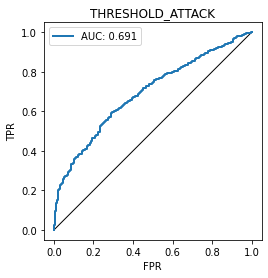

<Figure size 439.352x271.535 with 0 Axes>

<Figure size 439.352x271.535 with 0 Axes>

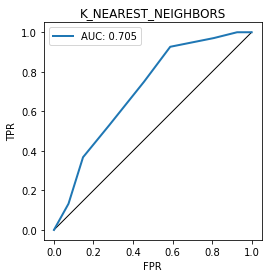

In [67]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import plotting

res = AttackResults.load(pth[0])
for i in range(3):
    plt.figure(figsize=nbfuns._DEFAULT_FIGSIZE)
    plotting.plot_roc_curve(res.single_attack_results[306+i].roc_curve)
    plt.title(res.single_attack_results[306+i].attack_type)
plt.show()

<Figure size 439.352x271.535 with 0 Axes>

<Figure size 439.352x271.535 with 0 Axes>

<Figure size 439.352x271.535 with 0 Axes>

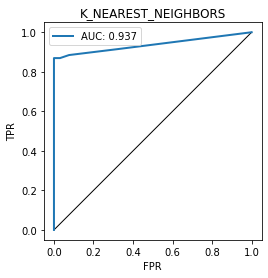

In [71]:
res = AttackResults.load(adult_results[5])
res.calculate_pd_dataframe()
for i in [12, 13, 14]:
    plt.figure(figsize=nbfuns._DEFAULT_FIGSIZE)
    plotting.plot_roc_curve(res.single_attack_results[i].roc_curve)
    plt.title(res.single_attack_results[i].attack_type)
plt.show()

In [21]:
dframes = []
for i, path in enumerate(paths):
    attacks_result = AttackResults.load(path)
    res_df = attacks_result.calculate_pd_dataframe()
    res_df.to_csv("./pickles/results-csv/" + pandas_names[i])
    new_df = pd.DataFrame(res_df[res_df["slice feature"] == "class"])
    zero_mean = new_df[new_df["slice value"] == str(0)].AUC.mean()
    ones_mean = new_df[new_df["slice value"] == str(1)].AUC.mean()
    new_df["Majority mean AUC"] = [zero_mean] * 6
    new_df["Minority mean AUC"] = [ones_mean] * 6
    new_df["Model"] = [names[i]] * 6
    dframes.append(new_df)
    
final_df = pd.concat(dframes)
cols = final_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_df = final_df[cols]
final_df.drop(columns=["Attacker advantage", "slice feature", "train size", "test size"], inplace=True, axis=1)
final_df

Model slice value          attack type       AUC  Majority mean AUC  \
3    LR           0     THRESHOLD_ATTACK  0.504061           0.504440   
4    LR           0        RANDOM_FOREST  0.502981           0.504440   
5    LR           0  K_NEAREST_NEIGHBORS  0.506279           0.504440   
6    LR           1     THRESHOLD_ATTACK  0.507372           0.504440   
7    LR           1        RANDOM_FOREST  0.503574           0.504440   
8    LR           1  K_NEAREST_NEIGHBORS  0.493611           0.504440   
3  DPLR           0     THRESHOLD_ATTACK  0.503017           0.502399   
4  DPLR           0        RANDOM_FOREST  0.499715           0.502399   
5  DPLR           0  K_NEAREST_NEIGHBORS  0.504465           0.502399   
6  DPLR           1     THRESHOLD_ATTACK  0.501197           0.502399   
7  DPLR           1        RANDOM_FOREST  0.489485           0.502399   
8  DPLR           1  K_NEAREST_NEIGHBORS  0.497863           0.502399   
3    RF           0     THRESHOLD_ATTACK  0.583879           0.573151   
4    RF           0        RANDOM_FOREST  0.575056           0.573151   
5    RF           0  K_NEAREST_NEIGHBORS  0.560517           0.573151   
6    RF           1     THRESHOLD_ATTACK  0.686879           0.573151   
7    RF           1        RANDOM_FOREST  0.715250           0.573151   
8    RF           1  K_NEAREST_NEIGHBORS  0.682992           0.573151   
3  DPRF           0     THRESHOLD_ATTACK  0.505888           0.502273   
4  DPRF           0        RANDOM_FOREST  0.492521           0.502273   
5  DPRF           0  K_NEAREST_NEIGHBORS  0.508410           0.502273   
6  DPRF           1     THRESHOLD_ATTACK  0.507199           0.502273   
7  DPRF           1        RANDOM_FOREST  0.478308           0.502273   
8  DPRF           1  K_NEAREST_NEIGHBORS  0.496298           0.502273   
3   CNB           0     THRESHOLD_ATTACK  0.503136           0.503243   
4   CNB           0        RANDOM_FOREST  0.509026           0.503243   
5   CNB           0  K_NEAREST_NEIGHBORS  0.497566           0.503243   
6   CNB           1     THRESHOLD_ATTACK  0.509057           0.503243   
7   CNB           1        RANDOM_FOREST  0.516774           0.503243   
8   CNB           1  K_NEAREST_NEIGHBORS  0.498529           0.503243   
3    DT           0     THRESHOLD_ATTACK  0.558501           0.556295   
4    DT           0        RANDOM_FOREST  0.556266           0.556295   
5    DT           0  K_NEAREST_NEIGHBORS  0.554119           0.556295   
6    DT           1     THRESHOLD_ATTACK  0.670584           0.556295   
7    DT           1        RANDOM_FOREST  0.662921           0.556295   
8    DT           1  K_NEAREST_NEIGHBORS  0.668505           0.556295   

   Minority mean AUC  
3           0.501519  
4           0.501519  
5           0.501519  
6           0.501519  
7           0.501519  
8           0.501519  
3           0.496181  
4           0.496181  
5           0.496181  
6           0.496181  
7           0.496181  
8           0.496181  
3           0.695040  
4           0.695040  
5           0.695040  
6           0.695040  
7           0.695040  
8           0.695040  
3           0.493935  
4           0.493935  
5           0.493935  
6           0.493935  
7           0.493935  
8           0.493935  
3           0.508120  
4           0.508120  
5           0.508120  
6           0.508120  
7           0.508120  
8           0.508120  
3           0.667337  
4           0.667337  
5           0.667337  
6           0.667337  
7           0.667337  
8           0.667337